In [32]:
import os
import re

import shutil
import codecs, json 
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import scipy as sp
from scipy import stats
import sklearn as sk
import time
from dypac import Dypac
import nilearn
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr
import nilearn.plotting as plotting
import hcp_utils as hcp

import helper_functions
import importlib

# Load data

In [33]:
#path to connectomes (created in the PreProcessingRSdata code)
feat_file = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/all_features_47.npz'

#path to subject IDs of connectomes
path_sub = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/subID_47.txt'

#path to behavioral data (analyzed in the analyze_behavior notebook)
path_behavior = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/Behavior/HCP_behavior_includeZscores.csv'

#load files
connectivity_data = np.load(feat_file)['a']
subject_IDs = np.loadtxt(path_sub, dtype=str)
df = pd.read_csv(path_behavior)

In [34]:
type(subject_IDs)
subject_IDs

array(['100307', '100408', '101107', '101309', '101915', '103111',
       '103414', '103818', '105014', '105115', '106016', '108828',
       '110411', '111312', '111716', '113619', '113922', '114419',
       '116524', '117122', '118528', '118730', '118932', '122317',
       '122620', '123117', '123925', '124422', '125525', '126325',
       '127630', '127933', '128127', '128632', '129028', '130013',
       '130316', '131217', '131722', '133019', '133928', '135225',
       '135932', '136833', '138534', '139637', '140925'], dtype='<U6')

In [35]:
#Convert subject nums from strings to integers
subject_IDs = list(map(int, subject_IDs))
print(subject_IDs)

[100307, 100408, 101107, 101309, 101915, 103111, 103414, 103818, 105014, 105115, 106016, 108828, 110411, 111312, 111716, 113619, 113922, 114419, 116524, 117122, 118528, 118730, 118932, 122317, 122620, 123117, 123925, 124422, 125525, 126325, 127630, 127933, 128127, 128632, 129028, 130013, 130316, 131217, 131722, 133019, 133928, 135225, 135932, 136833, 138534, 139637, 140925]


In [72]:
connectivity_data.shape

(47, 7, 7)

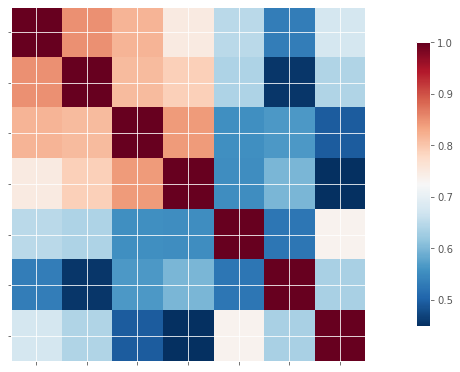

In [53]:
#visualize the connectome data
correlation_matrix = connectivity_data[1]
plotting.plot_matrix(correlation_matrix)
num_nodes = correlation_matrix.shape[0]

In [49]:
num_subs = df.shape[0]
print("Number of subjects in the behavior data is {0}".format(num_subs))
df.head(5)

Number of subjects in the behavior data is 844


,Unnamed: 0,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,...,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,z_score_mars,z_score_DDisc_AUC,z_score_Flanker,GroupType_f,z_score_compare_f
0,1,100206,S900,Q11,M,26-30,True,1,1,4,...,72.63,72.03,1.84,0.0,1.84,0.053852,-1.649623,1.435010,3,3.084632
1,2,100307,Q1,Q01,F,26-30,True,1,1,4,...,71.69,71.76,1.76,0.0,1.76,-0.120580,-0.720448,-0.031687,0,0.688761
2,3,100408,Q3,Q03,M,31-35,True,1,1,4,...,114.01,113.59,1.76,2.0,1.68,-0.295012,-0.329899,1.130657,3,1.460556
3,8,101309,S500,Q06,M,26-30,True,1,1,4,...,106.39,104.39,1.80,0.0,1.80,-0.033364,1.547886,0.115483,2,1.432402
4,9,101410,S500,Q06,M,26-30,False,2,1,2,...,73.86,71.78,1.80,0.0,1.80,-0.033364,-0.628364,-0.163840,0,0.464524


# Extract specific edges

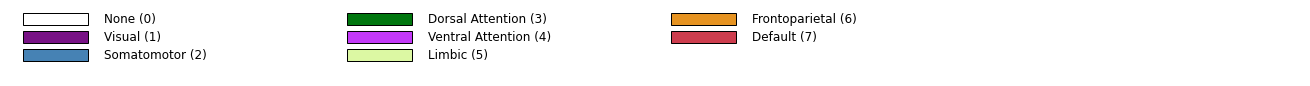

In [6]:
labels = hcp.parcellation_labels(hcp.yeo7)

In [10]:
#visual-Frontorarietal edge
connectivity_data[0][0,5]

0.2566775699492148

In [18]:
#Exctract only specific edge from the matrix- for each subject
specific_parcell_corr = []
num_node1 = 6
num_node2 = 3
for i in range(len(connectivity_data)):
    print(i)
    print (connectivity_data[i][num_node1,num_node2])
    specific_parcell_corr.append(connectivity_data[i][num_node1,num_node2])

0
-0.21637805566504936
1
0.4497982303745448
2
0.6545275146356032
3
0.08110881691413332
4
0.15045022261034335
5
-0.14292991126585478
6
-0.04797311921557231
7
0.17567894820528943
8
-0.0036075880422461624
9
-0.03212375542848711
10
0.26865220658955613
11
0.3492306968612354
12
0.30446291033112777
13
-0.04817325060603924
14
-0.3194956111568079
15
-0.11309250555657596
16
0.34906685745366595
17
0.10776629623478673
18
0.5031042152944155
19
0.056224343378707325
20
-0.3329665124513789
21
-0.1381850037240579
22
-0.0141747768565012
23
0.08749929772789754
24
-0.27599591937484985
25
-0.17211833052359013
26
0.2562193913991559
27
-0.06747063613695853
28
0.06929226753088699
29
0.01912092564158843
30
-0.10645426837280783
31
0.12752636259031916
32
-0.11287681253583462
33
0.4281505237456721
34
0.10407349953955973
35
0.008312614722160971
36
0.12684405754573588
37
0.07336291484266604
38
0.23616905886380163
39
0.40521269899182244
40
0.44905391484739227
41
0.26411715616528825
42
0.389230108451078
43
0.29316203

In [19]:
#convert list to dataframe
specific_parcell_corr  = pd.DataFrame(specific_parcell_corr, index = subject_IDs)
specific_parcell_corr.head(5)

,0
100307,-0.216378
100408,0.449798
101107,0.654528
101309,0.081109
101915,0.150450


# Filter edges and behavior data to equalize the number of subjects

In [85]:
#Filter the behavior data according to the edges data
behavior_clean = df.loc[df['Subject'].isin(subject_IDs)]
behavior_clean.shape

(42, 573)

In [86]:
#Set "subject" as index in the behavior data
behavior_clean = behavior_clean.set_index('Subject')
behavior_clean.head(5)

,Unnamed: 0,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,z_score_mars,z_score_DDisc_AUC,z_score_Flanker,GroupType_f,z_score_compare_f
Subject,,,,,,,,,,,,,,,,,,,,,
100307,2,Q1,Q01,F,26-30,True,1,1,4,100.0,...,71.69,71.76,1.76,0.0,1.76,-0.120580,-0.720448,-0.031687,0,0.688761
100408,3,Q3,Q03,M,31-35,True,1,1,4,100.0,...,114.01,113.59,1.76,2.0,1.68,-0.295012,-0.329899,1.130657,3,1.460556
101309,8,S500,Q06,M,26-30,True,1,1,4,100.0,...,106.39,104.39,1.80,0.0,1.80,-0.033364,1.547886,0.115483,2,1.432402
101915,11,Q3,Q04,F,31-35,True,2,2,4,100.0,...,112.11,111.70,1.84,1.0,1.80,-0.033364,1.454413,-1.313170,1,2.767582
103111,20,S500,Q06,M,26-30,True,1,1,4,100.0,...,109.15,107.30,1.80,0.0,1.80,-0.033364,0.434079,-0.738505,1,1.172584


In [22]:
#Filter the edges data according to the behavior data
specific_parcell_corr = specific_parcell_corr[specific_parcell_corr.index.isin(behavior_clean.index)]
specific_parcell_corr.shape

(42, 1)

# Examine link between specific cortical connection and behavior

In [90]:
#behavior scores of interest:
Flank_score = behavior_clean['Flanker_AgeAdj']

z_score_compare_f = behavior_clean['z_score_compare_f']

DelayDiscount_score = behavior_clean['DDisc_AUC_40K']

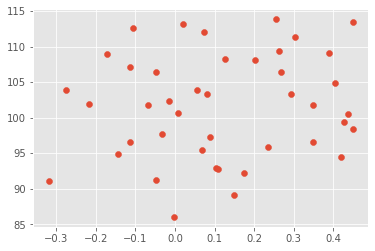

<AxesSubplot:xlabel='0', ylabel='Flanker_AgeAdj'>

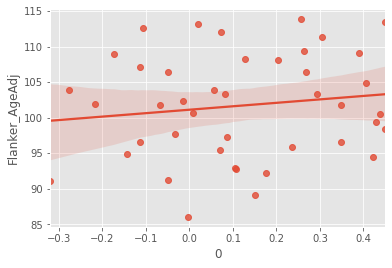

In [30]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

x = specific_parcell_corr[0]
y = Flank_score

plt.scatter(x, y)
plt.show()

sns.regplot(x, y)


In [31]:
import scipy as sc
from scipy import stats

sc.stats.pearsonr(x, y)

(0.14020343094125934, 0.375840324657336)

# Correlation matrix including all possible edges

In [108]:
#Exctract only specific edge from the matrix- for each subject
specific_parcell_corr = {}
for node1 in range(num_nodes):
    for node2 in range(node1+1,num_nodes):
        specific_parcell_corr[(node1,node2)] = []
        for i in range(len(connectivity_data)):
            specific_parcell_corr[(node1,node2)].append(connectivity_data[i][node1,node2])

In [109]:
len(specific_parcell_corr)

21

In [110]:
specific_parcell_corr_df = pd.DataFrame.from_dict(specific_parcell_corr, orient='index', columns = subject_IDs)
specific_parcell_corr_df.head(5)

,100307,100408,101107,101309,101915,103111,103414,103818,105014,105115,...,131217,131722,133019,133928,135225,135932,136833,138534,139637,140925
"(0, 1)",0.409531,0.849576,0.723919,0.660064,0.727986,0.366711,0.326221,0.683905,0.537825,0.407853,...,0.553590,0.680352,0.723742,0.698844,0.696310,0.651086,0.662019,0.732904,0.819142,0.755661
"(0, 2)",0.568716,0.817442,0.807598,0.620564,0.738575,0.540464,0.550118,0.725963,0.592210,0.414076,...,0.593396,0.725048,0.804569,0.750345,0.800093,0.741133,0.788068,0.781819,0.794863,0.739808
"(0, 3)",0.513882,0.748985,0.661372,0.645237,0.625916,0.438200,0.514498,0.588975,0.451483,0.509847,...,0.623794,0.678098,0.576770,0.634368,0.560762,0.642814,0.659973,0.555597,0.586281,0.605431
"(0, 4)",0.178257,0.650984,0.655447,0.374038,0.562832,-0.005520,0.162007,0.549604,0.321001,0.127362,...,0.308867,0.476160,0.687725,0.534850,0.614876,0.445846,0.529783,0.547428,0.640208,0.544154
"(0, 5)",0.256678,0.534900,0.617512,0.320549,0.516258,0.169355,0.289808,0.449034,0.265348,0.247764,...,0.458352,0.503660,0.446069,0.488606,0.234432,0.396599,0.571219,0.369462,0.434858,0.428428


In [111]:
#transpose the data frame so that the subjects would be the rows (so it would be easier to exclude)
specific_parcell_corr_df = specific_parcell_corr_df.transpose()
specific_parcell_corr_df.head(5)

,"(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(1, 2)","(1, 3)","(1, 4)","(1, 5)",...,"(2, 3)","(2, 4)","(2, 5)","(2, 6)","(3, 4)","(3, 5)","(3, 6)","(4, 5)","(4, 6)","(5, 6)"
100307,0.409531,0.568716,0.513882,0.178257,0.256678,0.053551,0.411272,0.285965,0.308914,0.089063,...,0.618162,0.173948,0.461334,-0.002861,0.025157,0.344253,-0.216378,0.250507,0.525428,0.442193
100408,0.849576,0.817442,0.748985,0.650984,0.534900,0.676123,0.811223,0.789467,0.640152,0.458038,...,0.841838,0.556995,0.567978,0.495531,0.553546,0.598811,0.449798,0.526700,0.734835,0.636633
101107,0.723919,0.807598,0.661372,0.655447,0.617512,0.665796,0.798468,0.814808,0.664025,0.674932,...,0.801045,0.673656,0.770577,0.698856,0.626210,0.801428,0.654528,0.642464,0.784535,0.760979
101309,0.660064,0.620564,0.645237,0.374038,0.320549,0.323032,0.693206,0.656897,0.426338,0.273119,...,0.757841,0.381043,0.493133,0.173625,0.334745,0.438037,0.081109,0.303868,0.452015,0.414719
101915,0.727986,0.738575,0.625916,0.562832,0.516258,0.493820,0.724464,0.594133,0.555467,0.371039,...,0.644982,0.503087,0.520557,0.336922,0.368245,0.462842,0.150450,0.508722,0.615892,0.645679


In [112]:
#Filter the edges data according to the behavior data
specific_parcell_corr_df = specific_parcell_corr_df[specific_parcell_corr_df.index.isin(behavior_clean.index)]
specific_parcell_corr_df.shape

(42, 21)

In [118]:
#Calculate the correlation of each specific edge with the behavioral measurement across subjects
x = z_score_compare_f
corr_data = []
for (columnName, columnData) in specific_parcell_corr_df.iteritems():
    print(sc.stats.pearsonr(x, columnData.values)[0])
    corr_data.append(sc.stats.pearsonr(x, columnData.values)[0])  

-0.2375321833536192
-0.2771316446157213
-0.1366666207848223
-0.19795637813097952
-0.19412802946996507
-0.24148247226069475
-0.14572982168885382
-0.14347379064272725
-0.15651650142521298
-0.2580212957103083
-0.2287495154859076
-0.0449707736113576
-0.21391850485507655
-0.1930045171174729
-0.25279500379200237
-0.15017655263423552
-0.34512592107152956
-0.20864756444251742
-0.20829433604751812
-0.19003656021346269
-0.1805084617596391


In [121]:
#convert list to dataframe
corr_data  = pd.DataFrame(corr_data, index = specific_parcell_corr.keys())
corr_data

0
0 1 -0.237532
  2 -0.277132
  3 -0.136667
  4 -0.197956
  5 -0.194128
  6 -0.241482
1 2 -0.145730
  3 -0.143474
  4 -0.156517
  5 -0.258021
  6 -0.228750
2 3 -0.044971
  4 -0.213919
  5 -0.193005
  6 -0.252795
3 4 -0.150177
  5 -0.345126
  6 -0.208648
4 5 -0.208294
  6 -0.190037
5 6 -0.180508

<AxesSubplot:ylabel='None-None'>

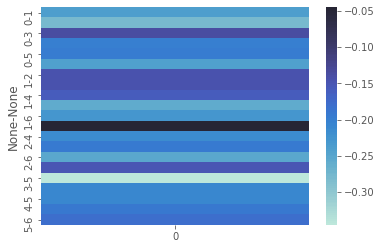

In [122]:
sns.heatmap(corr_data, center=0)